# Prophet Forecast

I'm going to use Facebook Prophet to do the forecasting, and see how it goes.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [3]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

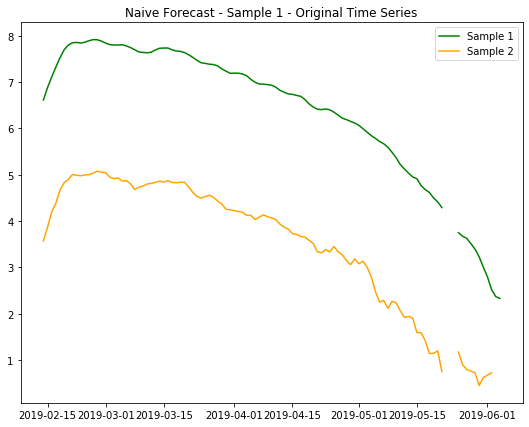

In [4]:
plt.figure(figsize=(9,7))
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Sample 1', color='green')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, color='green')
plt.plot(ts_moving_avg_train2.index, ts_moving_avg_train2, label='Sample 2', color='orange')
plt.plot(ts_moving_avg_test2.index, ts_moving_avg_test2, color='orange')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

## Logged Time Series

### Sample 1

In [5]:
train = pd.DataFrame(ts_log_train1.copy())
train['ds'] = train.index
train['y'] = ts_log_train1.values
train.drop(['client_count'], inplace=True, axis=1)
train.head()

,ds,y
purchase_date,,
2019-02-11,2019-02-11,6.152733
2019-02-12,2019-02-12,6.530878
2019-02-13,2019-02-13,6.775366
2019-02-14,2019-02-14,6.998510
2019-02-15,2019-02-15,7.229114


In [6]:
test = pd.DataFrame(ts_log_test1.copy())
test['ds'] = test.index
test['y'] = ts_log_test1.values
test.drop(['client_count'], inplace=True, axis=1)
test.head()

,ds,y
purchase_date,,
2019-05-22,2019-05-22,3.970292
2019-05-23,2019-05-23,3.713572
2019-05-24,2019-05-24,3.784190
2019-05-25,2019-05-25,3.526361
2019-05-26,2019-05-26,3.663562


In [8]:
import warnings
warnings.filterwarnings("ignore")

model_log1 = Prophet(daily_seasonality = True, yearly_seasonality=False, seasonality_mode = 'multiplicative',
                seasonality_prior_scale=0.1)  # seasonality_prior_scale decides the influence of seasonality
model_log1.fit(train)

In [9]:
periods = len(test.index)
print(periods)
future = model_log1.make_future_dataframe(periods=periods)
forecast = model_log1.predict(future)

forecast.head()

14


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-11,3.107089,6.225230,6.368898,3.107089,3.107089,1.01744,1.01744,1.01744,1.026730,1.026730,1.026730,0.009290,0.009290,0.009290,0.0,0.0,0.0,6.297232
1,2019-02-12,3.223908,6.463328,6.602412,3.223908,3.223908,1.01744,1.01744,1.01744,1.028246,1.028246,1.028246,0.010806,0.010806,0.010806,0.0,0.0,0.0,6.538879
2,2019-02-13,3.340727,6.690695,6.829889,3.340727,3.340727,1.01744,1.01744,1.01744,1.024252,1.024252,1.024252,0.006812,0.006812,0.006812,0.0,0.0,0.0,6.762472
3,2019-02-14,3.457546,6.872360,7.008911,3.457546,3.457546,1.01744,1.01744,1.01744,1.008714,1.008714,1.008714,-0.008726,-0.008726,-0.008726,0.0,0.0,0.0,6.945219
4,2019-02-15,3.568534,7.081437,7.219915,3.568534,3.568534,1.01744,1.01744,1.01744,1.003476,1.003476,1.003476,-0.013964,-0.013964,-0.013964,0.0,0.0,0.0,7.149474


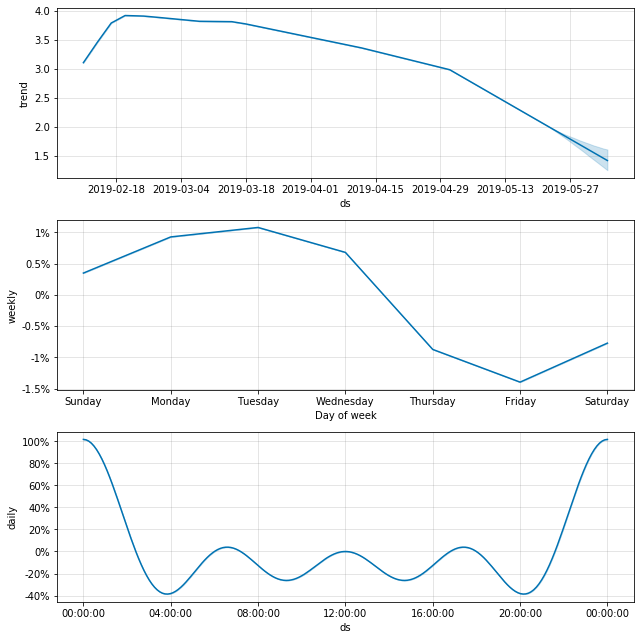

In [10]:
fig1 = model_log1.plot_components(forecast)

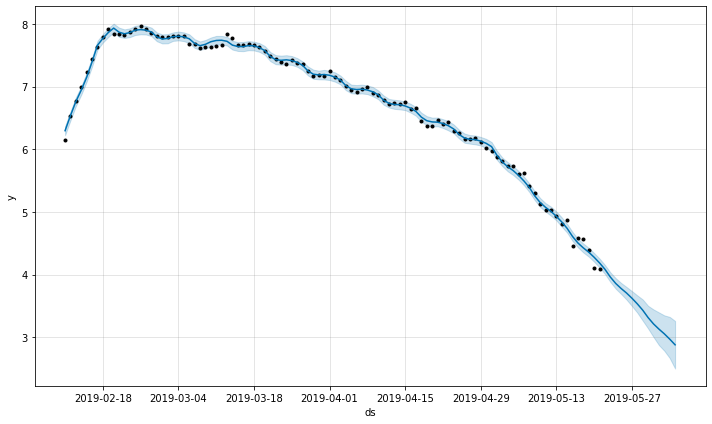

In [11]:
firg2 = model_log1.plot(forecast)

In [12]:
y_pred = forecast.loc[(forecast['ds']>=min(test.index)) & (forecast['ds']<=max(test.index))]['yhat']
y_pred.index = test.index
print(y_pred.shape)

y_pred.head()

(14,)


purchase_date
2019-05-22    4.086163
2019-05-23    3.962313
2019-05-24    3.859739
2019-05-25    3.779239
2019-05-26    3.707289
Name: yhat, dtype: float64

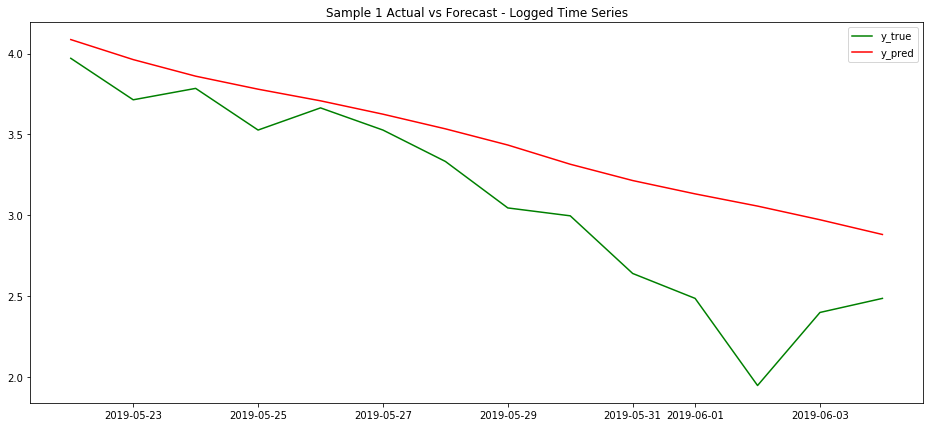

0.45643689349167504

In [26]:
plt.figure(figsize=(16,7))
plt.plot(ts_log_test1.index, ts_log_test1, label='y_true', color='green')
plt.plot(y_pred.index, y_pred, label = 'y_pred', color='red')
plt.legend(loc='best')
plt.title("Sample 1 Actual vs Forecast - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_log_test1, y_pred))
rmse

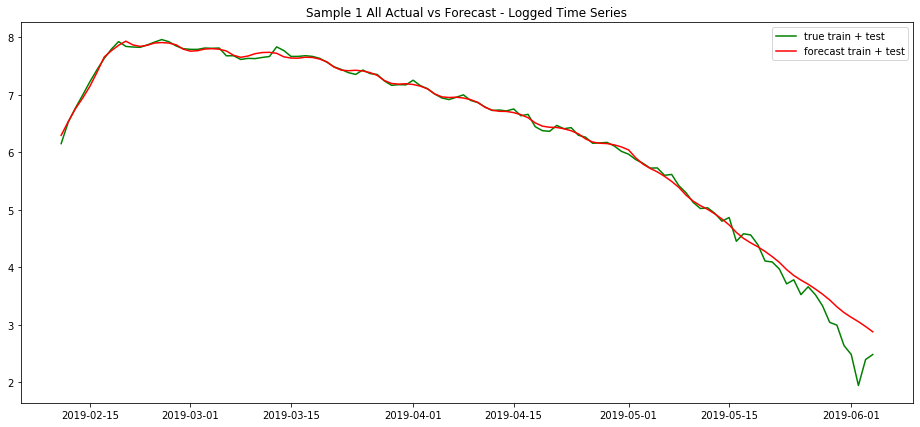

0.16813077034765836

In [27]:
y_all = forecast['yhat']
y_all.index = forecast['ds']

ts_log1 = ts_log_train1.copy()
ts_log1 = ts_log1.append(ts_log_test1)

plt.figure(figsize=(16,7))
plt.plot(ts_log1.index, ts_log1, label='true train + test', color='green')
plt.plot(y_all.index, y_all, label = 'forecast train + test', color='red')
plt.legend(loc='best')
plt.title("Sample 1 All Actual vs Forecast - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(ts_log1, y_all))
rmse

In [31]:
true_pred_df = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
true_pred_df['y_true'] = ts_log1.values
print(true_pred_df.shape)

true_pred_df.head()

(114, 5)


,ds,yhat_lower,yhat_upper,yhat,y_true
0,2019-02-11,6.225230,6.368898,6.297232,6.152733
1,2019-02-12,6.463328,6.602412,6.538879,6.530878
2,2019-02-13,6.690695,6.829889,6.762472,6.775366
3,2019-02-14,6.872360,7.008911,6.945219,6.998510
4,2019-02-15,7.081437,7.219915,7.149474,7.229114


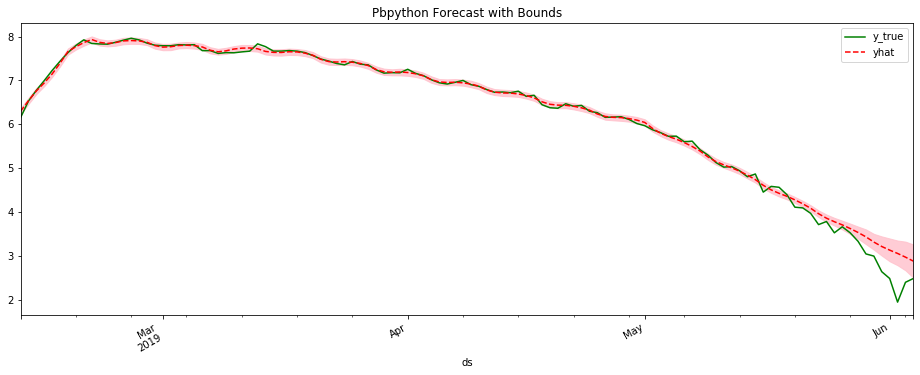

In [44]:
fig, ax = plt.subplots(figsize=(16, 7))
true_pred_df.plot(kind='line', x='ds', y=['y_true', 'yhat'], ax=ax, style=['-','--'], color=['green', 'red'])
ax.fill_between(true_pred_df['ds'].values, true_pred_df['yhat_lower'], true_pred_df['yhat_upper'], alpha=0.8, color='pink')
ax.set(title='Pbpython Forecast with Bounds')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')

#### Notes about Prophet

* It will forecast not only the testing data, but the whole time series. That's why I'm ploting both train and test data here.
* It seems that for logged sample 1, performance order:
  * moving window without param tuning > Prophet > moving window with param tuning